### Quick Example With the three different limitations 



In [25]:
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt 
import numpy as np
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display_html
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
def clean_objs(dff):
    dff = dff.copy()
    dff.loc[:,dff.dtypes == 'object'] = dff.loc[:,dff.dtypes == 'object'].applymap(lambda x: x.strip())
    return dff

In [4]:

## train data for large sample 
df = pd.read_csv('./data/large_train_sample.csv')

## test data
X_test = pd.read_csv('./data/test_data.csv')

## train data for cheap sample 
df_cheap_sample = pd.read_csv('./data/cheap_test_sample.csv')

In [5]:

y_test = pd.read_csv('./data/y_test.csv')

## I like having the target in classification stay as a string 
y_test['wage'] = y_test['wage'].map({1:'>50K', 0:'<=50K'})

In [6]:
df = clean_objs(df)
X_test = clean_objs(X_test)
df_cheap_sample = clean_objs(df_cheap_sample)

In [7]:
def percent_upper_income(col):
    return sum(1 for x in col if x == '>50K')/ len(col)

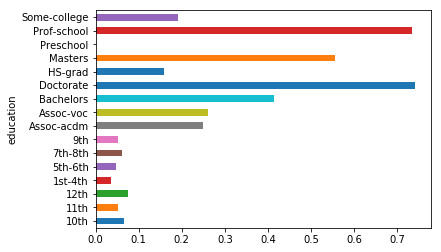

In [8]:
## looking at how to map education to integers 
df.groupby('education')['wage'].agg(percent_upper_income).plot(kind='barh');

In [9]:
df['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [10]:
highest = ['Prof-school', 'Doctorate']
assoc = ['Assoc-voc', 'Assoc-acdm']
hs = ['Some-college', 'HS-grad']

education_mapper = {}

for level in df['education'].unique():
    if level in highest:
        education_mapper[level] = 5
    elif level == 'Masters':
        education_mapper[level] = 4
    elif level == 'Bachelors':
        education_mapper[level] = 3
    elif level in assoc:
        education_mapper[level] = 2
    elif level in hs:
        education_mapper[level] = 1
    else:
        education_mapper[level] = 0 
education_mapper      

{'10th': 0,
 '11th': 0,
 '12th': 0,
 '1st-4th': 0,
 '5th-6th': 0,
 '7th-8th': 0,
 '9th': 0,
 'Assoc-acdm': 2,
 'Assoc-voc': 2,
 'Bachelors': 3,
 'Doctorate': 5,
 'HS-grad': 1,
 'Masters': 4,
 'Preschool': 0,
 'Prof-school': 5,
 'Some-college': 1}

In [11]:
## cleaning function 

def cleaner(df_in, is_test=False, train_df=None):
    df_in = df_in.copy()
    df_in['education'] =  df_in['education'].map(education_mapper)
    df_in = pd.get_dummies(df_in)
    if is_test:
        not_in_test = list(set(train_df.columns) - set(df_in.columns))
        not_in_train = list(set(df_in.columns) - set(train_df.columns))
        if len(not_in_test) > 0:
            new_col_df = pd.DataFrame(np.zeros((df_in.shape[0], len(not_in_test))), columns=not_in_test)
            df_in = pd.concat([df_in, new_col_df], axis=1)
        if len(not_in_train) > 0:
            df_in = df_in.drop(columns=not_in_train)
        
    return df_in 

In [12]:
## fitting rf on train full sample
X_train = cleaner(df.drop(columns=['wage']))
y_train = df['wage']
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

## fitting logreg on the full sample 
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train,y_train)
ss = StandardScaler()
X_train_ss =  ss.fit_transform(X_train)
lr.fit(X_train_ss, y_train)

## fitting rf on train cheap sample 
X_cheap_sample = cleaner(df_cheap_sample.drop(columns=['wage']))
y_train_cheap = df_cheap_sample['wage']
rf_cheap = RandomForestClassifier(n_estimators=100)
rf_cheap.fit(X_cheap_sample, y_train_cheap)

## fitting rf on train limited to 20 featuers 
X_train = cleaner(df.drop(columns=['wage']))
y_train = df['wage']
skb20 = SelectKBest(k=20)
X_train_20 = skb20.fit_transform(X_train, y_train)
rf20 = RandomForestClassifier(n_estimators=100)
rf20.fit(X_train_20,y_train);


//anaconda/envs/three/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda/envs/three/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [13]:
## creating test sets for each model 
X_test_model = cleaner(X_test, is_test=True, train_df=X_train)
X_test_model_cheap_sample = cleaner(X_test, is_test=True, train_df=X_cheap_sample)

## generating predictions for each model 
predict_probas_cheap = rf_cheap.predict_proba(X_test_model_cheap_sample)[:,1]
predict_probas = rf.predict_proba(X_test_model)[:,1]
predict_probas_lr = lr.predict_proba(ss.transform(X_test_model))[:,1]
predict_probas_20 = rf20.predict_proba(skb20.transform(X_test_model))[:,1]

//anaconda/envs/three/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [14]:
from roc_plotting_functions import plot_model

In [15]:
interact(plot_model,y_test=fixed(y_test), threshold =(-.01,1.01, .01), probas1=fixed(predict_probas), descrip1=fixed('No Limitations'),\
        probas2= fixed(predict_probas_cheap), descrip2=fixed('Limited Data'));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.01, min=-0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

,No Limitations RF,Log Reg
Accuracy Score,0.8937,0.9759
AUC_ROC,0.9721,0.9956


No Limitations RF 
 
 
 
 Predicted <=50K 
 Predicted >50K 
 
 
 
 
 True <=50K 
 11615 
 1497 
 
 
 True >50K 
 233 
 2936 
 
 
 
 
 
 
 Log Reg 
 
 
 
 Predicted <=50K 
 Predicted >50K 
 
 
 
 
 True <=50K 
 12827 
 285 
 
 
 True >50K 
 108 
 3061

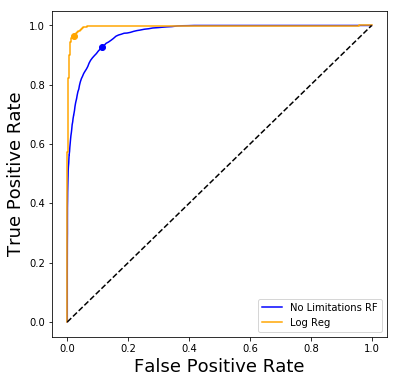

In [41]:
plot_model(.33, y_test, predict_probas, 'No Limitations RF', predict_probas_lr, 'Log Reg')

,No Limitations,Twenty Features
Accuracy Score,0.9176,0.8756
AUC_ROC,0.9721,0.9390


No Limitations 
 
 
 
 Predicted <=50K 
 Predicted >50K 
 
 
 
 
 True <=50K 
 12174 
 938 
 
 
 True >50K 
 403 
 2766 
 
 
 
 
 
 
 Twenty Features 
 
 
 
 Predicted <=50K 
 Predicted >50K 
 
 
 
 
 True <=50K 
 11685 
 1427 
 
 
 True >50K 
 599 
 2570

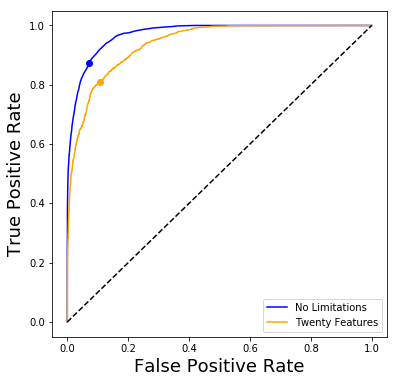

In [17]:
plot_model(.4, y_test, predict_probas, 'No Limitations', predict_probas_20, 'Twenty Features')

In [27]:
## for trying different models
def get_probabilities_from_model(model):
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)
    return pipe.predict_proba(X_test_model)[:,1]

,Gradient Boosting,KNN
Accuracy Score,0.9351,0.8056
AUC_ROC,0.9787,0.6962


Gradient Boosting 
 
 
 
 Predicted <=50K 
 Predicted >50K 
 
 
 
 
 True <=50K 
 12359 
 753 
 
 
 True >50K 
 304 
 2865 
 
 
 
 
 
 
 KNN 
 
 
 
 Predicted <=50K 
 Predicted >50K 
 
 
 
 
 True <=50K 
 12972 
 140 
 
 
 True >50K 
 3025 
 144

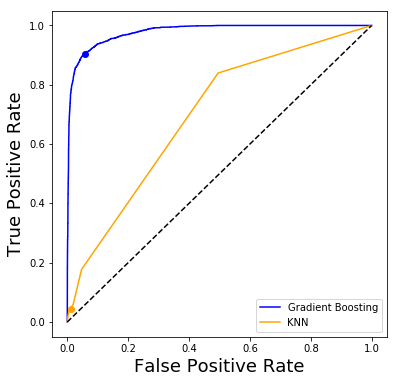

In [42]:
plot_model(.4, y_test, get_probabilities_from_model(GradientBoostingClassifier()), 'Gradient Boosting',\
          get_probabilities_from_model(KNeighborsClassifier(9)), 'KNN')

In [37]:
## logreg coefficients 

pd.DataFrame(lr.coef_, columns=X_train.columns).T.sort_values(0)

,0
marital-status_Never-married,-0.529180
relationship_Own-child,-0.298342
occupation_Priv-house-serv,-0.270760
occupation_Other-service,-0.260259
marital-status_Divorced,-0.223143
sex_Female,-0.202912
occupation_Farming-fishing,-0.177415
workclass_Without-pay,-0.143369
occupation_Handlers-cleaners,-0.142527
marital-status_Separated,-0.138773
